In [1]:

import pandas as pd
import numpy as np

import torch
import os
import time
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.itertools import batcher
from forecaster import ForecastConfig, HeadForecaster
import matplotlib.pyplot as plt
device = "cuda:7"

In [2]:
def load_test_data(pred_length, context, quantiles, dataset, forecast_date, stride=1):
    PDT = pred_length
    CTX = context

    # Load dataframe and GluonTS dataset
    df = pd.read_csv(dataset, index_col=0, parse_dates=['ds'])
    df['y'] = df['y'].astype(np.float32)
    # df = pd.read_csv(dataset, index_col=False, parse_dates=['ds'])
    ds = PandasDataset.from_long_dataframe(df, target="y", item_id="unique_id", timestamp='ds')
    freq = ds.freq
    unit = ''.join(char for char in freq if not char.isdigit())
    print(f'freq: {freq}, unit: {unit}')
    unit_str = "".join(filter(str.isdigit, freq))
    if unit_str == "":
        unit_num = 1
    else:
        unit_num = int("".join(unit_str))
    if unit == 'M':
        freq_delta = pd.DateOffset(months=unit_num)
    else:
        freq_delta = pd.Timedelta(unit_num, unit)

    
    if forecast_date == "":
        forecast_date = min(df['ds']) + freq_delta * CTX
    else:
        forecast_date = pd.Timestamp(forecast_date)
    end_date = max(df['ds'])
    if unit == 'M':
        total_forecast_length = (end_date.to_period(unit)-forecast_date.to_period(unit)).n // unit_num + 1
    else:
        total_forecast_length = (end_date-forecast_date) // freq_delta

    _, test_template = split(
        ds, date=pd.Period(forecast_date, freq=freq)
    )

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,  # number of time steps for each prediction
        windows=(total_forecast_length-PDT)//stride,  # number of windows in rolling window evaluation
        distance=stride,  # number of time steps between each window - distance=PDT for non-overlapping windows
        max_history=CTX,
    )
    return test_data, freq, unit, freq_delta

In [3]:
pred_length = 64
context_len = 512
quantiles = [10,20,30,40,50,60,70,80,90]
# dataset = 'data/amazon-google/y_amazon-google.csv'
dataset_name = "amazon-google-large"
model_name = "yinglong"
# enter entire dataset path to argparse
dataset = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset_name}/y_{dataset_name}.csv"
save_dir = f"model_results/{dataset_name}/{model_name}"
forecast_date = "2021-01-31 23:00:00"
stride = 64
batch_size = 512
test_data, freq, unit, freq_delta = load_test_data(pred_length, context_len, quantiles, dataset, forecast_date, stride=stride)
# Build forecaster for a given model (e.g., timesfm)
cfg = ForecastConfig(model_name=model_name, context_len=context_len, horizon_len=None, ckpt_dir="models")
forecaster = HeadForecaster(cfg)

# Load desired heads (auto-discovers checkpoints at models/{model}_{head}_head.pt)
all_heads = ["quantiles", "studentst", "gaussian", "mixture"]
loaded = forecaster.load_heads(all_heads)
print("Loaded heads:", loaded)
all_heads.append("backbone")
# 


freq: H, unit: H
Loaded heads: ['quantiles', 'studentst', 'gaussian', 'mixture']


In [4]:
start_time = time.time()
item_id_col = []
start_date_col = []
forecasts = dict()
for head in all_heads:
    forecasts[head] = []

for i, batch in enumerate(batcher(test_data.input, batch_size=batch_size)):
    start_forecast = time.time()
    context = torch.stack([torch.tensor(entry["target"]) for entry in batch])
    # x, y, z, ids = load_dataset("amazon-google-large", pred_length=128, ds=ds)
    # context = x
    out = forecaster.forecast(context)
    break
    print(f"batch {i}: single iteration: {time.time()-start_forecast:.3f} total time: {time.time()-start_time:.3f}")
    item_id_col.append(np.array([entry["item_id"] for entry in batch]))
    start_date_col.append(np.array([entry["start"] for entry in batch]) + context_len-1)
    for head in all_heads:
        forecasts[head].append(np.concatenate([out[head]['median'][None, ...], 
                                            out[head]['quantiles']], 
                                            axis=0))

# os.makedirs(save_dir, exist_ok=True)
# columns = ['unique_id', 'ds', *range(1,pred_length+1)]
# item_id_col = np.concatenate(item_id_col, axis=0)
# start_date_col = np.concatenate(start_date_col, axis=0)
# for head in all_heads:
#     os.makedirs(f"{save_dir}/{head}", exist_ok=True)
#     forecasts[head] = np.concatenate(forecasts[head], axis=1)
#     for pred_type_ind, pred_type in enumerate(["median"] + quantiles):
#         data_dict = {
#             "unique_id": item_id_col,
#             "ds": start_date_col
#         }
#         for pred_dist in range(pred_length):
#             data_dict[str(pred_dist + 1)] = forecasts[head][pred_type_ind, :, pred_dist]
#         df = pd.DataFrame(data_dict)
#         df.to_csv(f"{save_dir}/{head}/{pred_type}_preds.csv")
    

In [5]:
# out["heads"]["quantiles"]['median'].shape
out['quantiles']['quantiles'].shape
out['backbone']['quantiles'].shape

torch.Size([9, 512, 128])

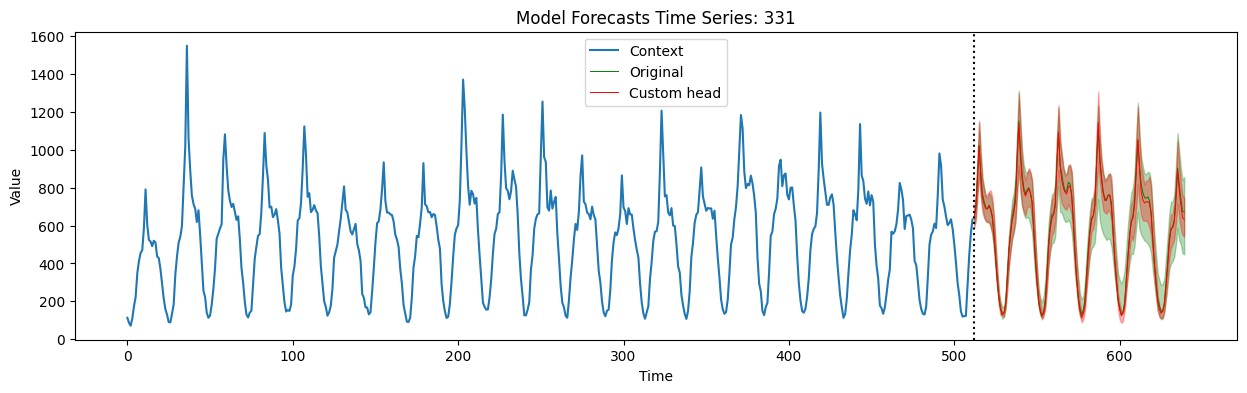

In [6]:
ind = np.random.randint(context.shape[0])
head_type = "quantiles"
plt.figure(figsize=(15,4))
plt.plot(context[ind], label="Context")
# plt.plot(np.arange(y.shape[1]) + context_len, y[ind].detach().cpu(), color='purple', label='True Value', lw=1)

# quantiles_backbone = out['backbone']['quantiles']
quantiles_backbone = out["backbone"]['quantiles']
quantiles_head = out[head_type]['quantiles']
median_head = out[head_type]['median']
plt.plot(np.arange(quantiles_backbone.shape[2]) + context_len, quantiles_backbone[4, ind, :], color='green', label='Original', lw=0.7)
plt.fill_between(np.arange(quantiles_backbone.shape[2]) + context_len, quantiles_backbone[0, ind, :], quantiles_backbone[8, ind, :], color='green', alpha=0.3)

plt.plot(np.arange(quantiles_head.shape[2]) + context_len, median_head[ind].detach().cpu(), color='red', label='Custom head', lw=0.7)
plt.fill_between(np.arange(quantiles_head.shape[2]) + context_len, quantiles_head[0, ind], quantiles_head[8, ind], color='red', alpha=0.3)

plt.axvline(context_len, color="black", ls=':')
# for i in range(step_size, horizon_len+1, step_size):
#     plt.axvline(context_len + i, color="black", ls=':', alpha=0.1)
plt.title(f"Model Forecasts Time Series: {ind}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [6]:
import einops
from uni2ts.model.moirai2 import (Moirai2Forecast, Moirai2Module)
model = Moirai2Forecast(
    module=Moirai2Module.from_pretrained("Salesforce/moirai-2.0-R-small"),
    prediction_length=pred_length,
    context_length=context_len,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
patch_len = 16
model.module.eval()
model.module.to(device)

context_ = context.to(device)[:, :, None]
target, observed_mask, sample_id, time_id, variate_id, prediction_mask = model._convert(
    patch_size=patch_len,
    past_target=context_,
    past_observed_target=torch.isfinite(context_),
    past_is_pad=torch.full_like(context_[:, :, 0], False, dtype=bool),
)
if model_name == "moirai2":
    patch_sizes = False
else:
    patch_sizes = torch.ones_like(time_id, dtype=torch.long) * patch_len
# model.module.get_reprs = True
# transformer_output, stats = model.module(
#     target, observed_mask, sample_id, time_id, variate_id, prediction_mask, patch_sizes
# )
# transformer_output = transformer_output[:,context_len//patch_len-1,:].detach().cpu()
# stats = stats[:,0,:]
# model.module.get_reprs = False
forecasts = model.module(target, observed_mask, sample_id, time_id, variate_id, prediction_mask, patch_sizes)
quantile_forecasts = einops.rearrange(
    forecasts[:, context_len // patch_len, :],
    "B (pred_len quantiles) -> quantiles B pred_len",
    quantiles=9, pred_len=pred_length
).detach().cpu()

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

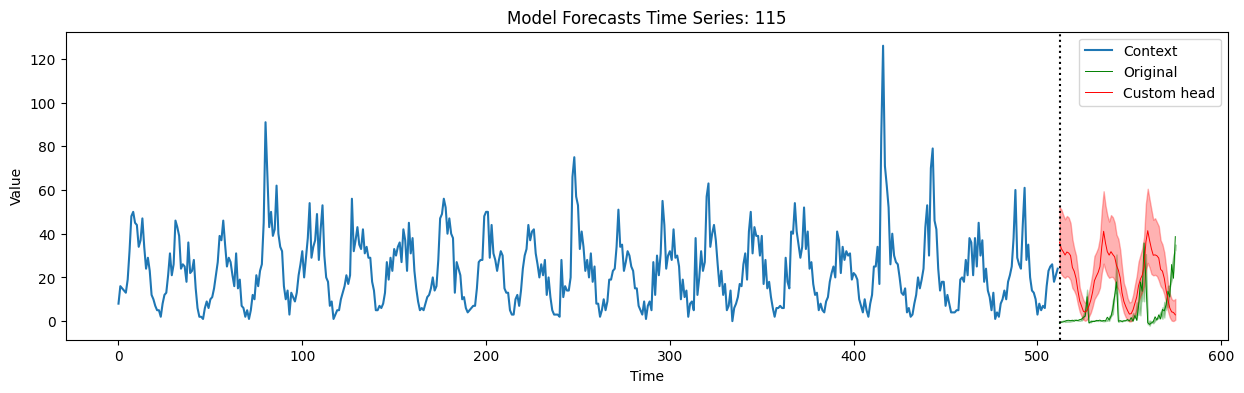

In [ ]:
# Plot Examples
ind = np.random.randint(batch_size)
head_type = "quantiles"
plt.figure(figsize=(15,4))
plt.plot(context[ind], label="Context")
# plt.plot(np.arange(y.shape[1]) + context_len, y[ind].detach().cpu(), color='purple', label='True Value', lw=1)

# quantiles_backbone = out['backbone']['quantiles']
quantiles_backbone = quantile_forecasts
quantiles_head = out[head_type]['quantiles']
median_head = out[head_type]['median']
plt.plot(np.arange(quantiles_backbone.shape[2]) + context_len, quantiles_backbone[4, ind, :], color='green', label='Original', lw=0.7)
plt.fill_between(np.arange(quantiles_backbone.shape[2]) + context_len, quantiles_backbone[0, ind, :], quantiles_backbone[8, ind, :], color='green', alpha=0.3)

plt.plot(np.arange(quantiles_head.shape[2]) + context_len, median_head[ind].detach().cpu(), color='red', label='Custom head', lw=0.7)
plt.fill_between(np.arange(quantiles_head.shape[2]) + context_len, quantiles_head[0, ind], quantiles_head[8, ind], color='red', alpha=0.3)

plt.axvline(context_len, color="black", ls=':')
# for i in range(step_size, horizon_len+1, step_size):
#     plt.axvline(context_len + i, color="black", ls=':', alpha=0.1)
plt.title(f"Model Forecasts Time Series: {ind}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

ds_ind: 7135
torch.Size([235, 13000]) (235, 13000)
batch 0: single iteration: 16.504 total time: 16.522
(64,)


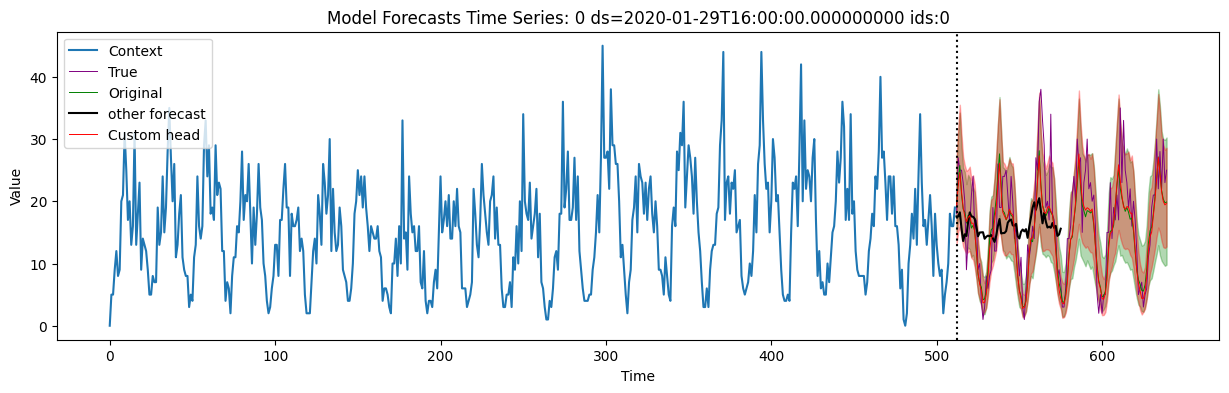

In [8]:
import datetime
def load_dataset(dataset, ts=1000, pred_length=1, ctx_len=512, ds=None):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'])
            y.append(val_dict['future_values'])
        x = torch.stack(x)[:, -ctx_len:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        z = []
        ids = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
            z.append(vals[timestamp_column].to_numpy())
            ids.append(id)
        x = torch.stack(x)
        z = np.concatenate(z).reshape(len(data.groupby('unique_id')),-1)
        ds_ind = np.where(z[0] == pd.Timestamp(ds))[0][0]
        print(f"ds_ind: {ds_ind}")
        print(x.shape, z.shape)

        # y = x[:,24*7+ctx_len:24*7+ctx_len+pred_length]
        # x = x[:,24*7:24*7+ctx_len]
        y = x[:, ds_ind+1:ds_ind+pred_length+1]
        x = x[:, ds_ind-ctx_len+1:ds_ind+1]

    return x, y, z, ids
ds = "2020-10-24 15:00"
df = pd.read_csv("model_results/amazon-google-large/yinglong/quantiles/median_preds.csv", parse_dates=['ds'])
ind = 0
forecasts = df.loc[(df['unique_id']==ind) & (df['ds']==ds), [str(i+1) for i in range(64)]].to_numpy().flatten()

x, y, z, ids = load_dataset("amazon-google-large", pred_length=128, ds=ds)
context = x
out = forecaster.forecast(context)
print(f"batch {i}: single iteration: {time.time()-start_forecast:.3f} total time: {time.time()-start_time:.3f}")
print(forecasts.shape)
# item_id_col.append(np.array([entry["item_id"] for entry in batch]))
# start_date_col.append(np.array([entry["start"] for entry in batch]))
# for head in all_heads:
#     forecasts[head].append(np.concatenate([out[head]['median'][None, ...], 
#                                         out[head]['quantiles']], 
#                                         axis=0))
    
# ind = np.random.randint(context.shape[0])
# ind = 0
head_type = "quantiles"
plt.figure(figsize=(15,4))
plt.plot(context[ind], label="Context")
plt.plot(np.arange(y.shape[1]) + context_len, y[ind], color='purple', label='True', lw=0.7)
# plt.plot(np.arange(y.shape[1]) + context_len, y[ind].detach().cpu(), color='purple', label='True Value', lw=1)

# quantiles_backbone = out['backbone']['quantiles']
quantiles_backbone = out["backbone"]['quantiles']
quantiles_head = out[head_type]['quantiles']
median_head = out[head_type]['median']

plt.plot(np.arange(quantiles_backbone.shape[2]) + context_len, quantiles_backbone[4, ind, :], color='green', label='Original', lw=0.7)
plt.fill_between(np.arange(quantiles_backbone.shape[2]) + context_len, quantiles_backbone[0, ind, :], quantiles_backbone[8, ind, :], color='green', alpha=0.3)

plt.plot(np.arange(forecasts.shape[0]) + context_len, forecasts, color='black', label='other forecast')

plt.plot(np.arange(quantiles_head.shape[2]) + context_len, median_head[ind].detach().cpu(), color='red', label='Custom head', lw=0.7)
plt.fill_between(np.arange(quantiles_head.shape[2]) + context_len, quantiles_head[0, ind], quantiles_head[8, ind], color='red', alpha=0.3)

plt.axvline(context_len, color="black", ls=':')
# for i in range(step_size, horizon_len+1, step_size):
#     plt.axvline(context_len + i, color="black", ls=':', alpha=0.1)
plt.title(f"Model Forecasts Time Series: {ind} ds={z[ind,24*7+context_len]} ids:{ids[ind]}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()